## Part 1

In [1]:
from scipy.special import beta
import numpy as np

a = 0
b = 10
c = 100

E = (a + 4*b + c)/6
var = (E - a) * (c - E) / 7
print(f"E[X] = {E}")
print(f"var[X] = {var}")

def p(x, a=0, b=10, c=100):
    x = np.array(x, dtype=np.float64)

    alpha = 1 + 4 * (b - a) / (c - a)
    beta_ = 1 + 4 * (c - b) / (c - a)

    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= c)

    num = (x[mask] - a) ** (alpha - 1) * (c - x[mask]) ** (beta_ - 1)
    denom = beta(alpha, beta_) * (c - a) ** (alpha + beta_ - 1)

    pdf[mask] = num / (denom + 1e-8)
    return pdf

E[X] = 23.333333333333332
var[X] = 255.55555555555557


### Plot distribution

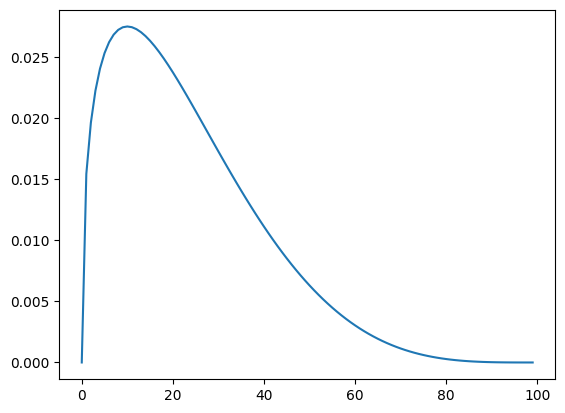

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x_vec = np.arange(a,c,1)
vals = [p(x) for x in x_vec]
plt.plot(x_vec, vals)

### 1.1

In [3]:
def expected_value_integrand_p(x):
    return p(x) * x

def trapezoidal(fun, x0, xn, n):
    interval = (xn - x0) / n
    integral = 0
    
    x_prev = x0

    # the + interval/10 is only so that we get to the last xn point before stopping
    for x in np.arange(x0 + interval, xn + interval / 10, interval): 
        integral += (x - x_prev)/2 * (fun(x) + fun(x_prev))

        x_prev = x

    return integral

for n in range(1,500):
    diff = np.abs(E - trapezoidal(expected_value_integrand_p, a, c, n)) 
    if diff < 5e-5:
        print(f"Difference between actual E[X] and approximated")
        print("---------------------------------------------------------")
        print(f"E[x] - E_hat[X] = {diff} using {n} evaluations")
        break

Difference between actual E[X] and approximated
---------------------------------------------------------
E[x] - E_hat[X] = 4.957722734388881e-05 using 271 evaluations


### 1.2

In [4]:
# Pilot run
N_pilot = 10**8
x_samples = np.random.uniform(0, 100, N_pilot)
f_samples = x_samples * p(x_samples)  *100 # because of the (c-a)
sigma_hat = np.std(f_samples, ddof=1)
print(f"We estimated sigma = {sigma_hat}")

# Get the number of points needed
n = (1.96 * sigma_hat / 0.005) ** 2
n= int(np.ceil(n))
print(f"We need {n} samples")

We estimated sigma = 19.080733526739085
We need 55945128 samples


### 1.3

In [5]:
from tqdm import tqdm
np.random.seed(42)

diffs = []
averages = []
stds = []

n = 55935632

for _ in tqdm(range(200)):
    estimates = []

    x = np.random.uniform(0,100, size=n)
    # times 100 because we used importance sampling 
    fx = 100 * expected_value_integrand_p(x)

    averages.append(np.mean(fx))

    stds.append(np.std(fx))

    # Actual diff
    diff = np.mean(fx) - E

    diffs.append(diff)


100%|██████████| 200/200 [14:20<00:00,  4.30s/it]


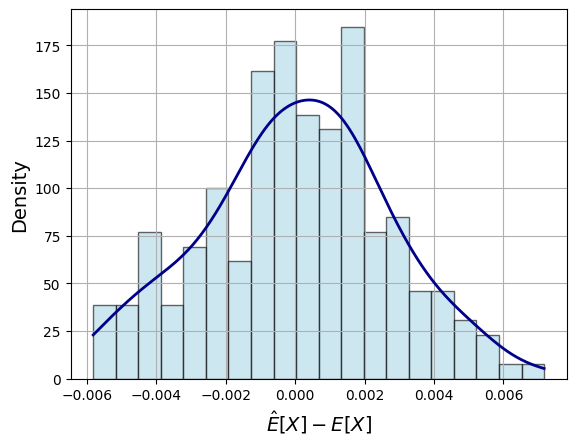

In [6]:
# Plot the distribution of differences to the actual value
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Histogram
plt.hist(diffs, bins=20, density=True, color="lightblue", edgecolor="black", alpha=0.6)

# Fit KDE
density = gaussian_kde(diffs)
x_vals = np.linspace(min(diffs), max(diffs), 300)
plt.plot(x_vals, density(x_vals), color="darkblue", linewidth=2)

plt.xlabel(r"$\hat{E}[X] - E[X]$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(True)
plt.savefig("report/figures/diff.png")

## Part 2

### 2.1

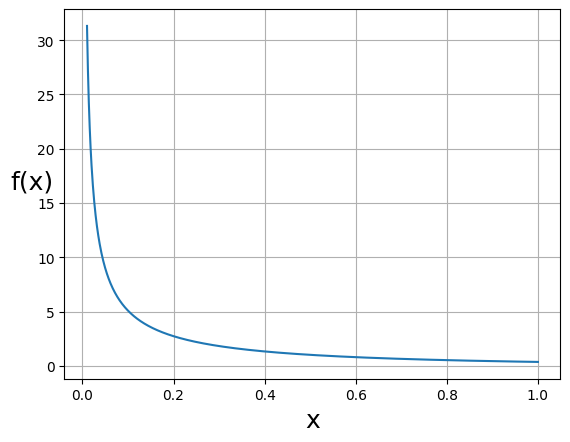

In [7]:
def integrand(x):
    return x**(-0.75) * np.exp(-x)

x = np.linspace(1e-2,1, 1000)
plt.plot(x, integrand(x))
plt.xlabel("x",fontsize=18)
plt.ylabel("f(x)", rotation=0,fontsize=18)
plt.grid(True)
plt.savefig("report/figures/f.png")

### 2.2

In [8]:
np.random.seed(42)
n = 10**7

estimates = []


for _ in range(10):
    x = np.random.uniform(0,1, n)
    fx = integrand(x)

    estimates.append(np.mean(fx))

print(f"{np.mean(estimates)} +/- {np.std(estimates)}")


3.3639559852290715 +/- 0.08895371562338893


### 2.3

In [9]:
def q(x, c = 1/4):
    return c * x**(-3/4)

def q_cdf(x):
    return x**(1/4)

def q_cdf_inv(x):
    return x**4

np.random.seed(42)
n = 10**7
estimates = []

for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = q_cdf_inv(u)  # samples from q(x)
    fx = integrand(x)
    qx = q(x)
    weights = fx / qx

    estimates.append(np.mean(weights))


print(f"{np.mean(estimates)} +/- {np.std(estimates)}")

3.379466236404859 +/- 0.00014274478809652816


## 3

In [10]:
def autocorr(x, lag):
    n = len(x)
    if lag >= n:
        return np.nan
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

def compute_ess(x, max_lag=None):
    n = len(x)
    if max_lag is None:
        max_lag = min(n // 2, 1000)

    rho_sum = 0
    for lag in range(1, max_lag):
        rho = autocorr(x, lag)
        if np.isnan(rho) or rho < 0:
            break
        rho_sum += rho

    return n / (1 + 2 * rho_sum)

In [11]:
x_data = np.array([0.3, 0.5, 0.75, 0.4])

def posterior(alpha, eta, data = x_data):
    if eta <= 0 or alpha <= 0:
        return 0

    likelihood = alpha * eta * data**(alpha - 1) * np.exp(-eta * data**alpha)
    likelihood = np.prod(likelihood)
    prior = np.exp((-alpha - 2 * eta)) * eta

    return likelihood * prior


### 3.1 Normal proposal

In [12]:
def metropolis_hastings_normal(initial_state, cov, N = 1000, posterior = posterior):
    samples = [np.array(initial_state)]

    accept_count = 0

    for _ in range(N):
        current = samples[-1]
        proposal = np.random.multivariate_normal(mean=current, cov=cov)

        p_current = posterior(current[0], current[1])
        p_proposal = posterior(proposal[0], proposal[1])

        if p_current == 0:
            accept_ratio = 1
        else:
            accept_ratio = min(p_proposal / p_current, 1)
        
        if accept_ratio >= np.random.rand():
            samples.append(proposal)
            accept_count += 1

        else:
            samples.append(current)

    accept_rate = accept_count / N

    return np.array(samples), accept_rate


### Trying a few different cov matrices

In [13]:
np.random.seed(52)

cov_matrices = [
    # Small 
    np.array([[0.1, 0.0],
              [0.0,  0.1]]),

    # Larger 
    np.array([[1, 0.0],
              [0.0,  1]]),

    # Slightly correlated
    np.array([[0.5, 0.01],
              [0.01, 0.5]]),

    # Stronger correlation 
    np.array([[0.5, 0.05],
              [0.05, 0.5]]),

    # More aggressive steps for η
    np.array([[1, 0.0],
              [0.0,  0.1]]),

    # More aggressive steps for α
    np.array([[0.1, 0.0],
              [0.0,  1]])
]

num_chains = 5
num_samples = 1000

for cov in cov_matrices:
    total_ess_alpha = 0
    total_ess_eta = 0
    total_accept_rate = 0

    for _ in range(num_chains):
        samples, accept_ratio = metropolis_hastings_normal([1, 1], cov, num_samples)
        samples = np.array(samples)


        ess_alpha = compute_ess(samples[:, 0])
        ess_eta = compute_ess(samples[:, 1])

        total_ess_alpha += ess_alpha
        total_ess_eta += ess_eta
        total_accept_rate += accept_ratio

    avg_accept_rate = total_accept_rate / num_chains

    print(f"Covariance matrix:\n{cov}")
    print(f"Average acceptance rate: {avg_accept_rate:.3f}")
    print(f"Sum of ESS for alpha (5 chains): {total_ess_alpha:.1f}")
    print(f"Sum of ESS for eta (5 chains): {total_ess_eta:.1f}\n")


Covariance matrix:
[[0.1 0. ]
 [0.  0.1]]
Average acceptance rate: 0.757
Sum of ESS for alpha (5 chains): 163.5
Sum of ESS for eta (5 chains): 130.6

Covariance matrix:
[[1. 0.]
 [0. 1.]]
Average acceptance rate: 0.397
Sum of ESS for alpha (5 chains): 622.9
Sum of ESS for eta (5 chains): 549.5

Covariance matrix:
[[0.5  0.01]
 [0.01 0.5 ]]
Average acceptance rate: 0.503
Sum of ESS for alpha (5 chains): 406.3
Sum of ESS for eta (5 chains): 510.2

Covariance matrix:
[[0.5  0.05]
 [0.05 0.5 ]]
Average acceptance rate: 0.520
Sum of ESS for alpha (5 chains): 418.4
Sum of ESS for eta (5 chains): 378.0

Covariance matrix:
[[1.  0. ]
 [0.  0.1]]
Average acceptance rate: 0.520
Sum of ESS for alpha (5 chains): 676.9
Sum of ESS for eta (5 chains): 83.3

Covariance matrix:
[[0.1 0. ]
 [0.  1. ]]
Average acceptance rate: 0.535
Sum of ESS for alpha (5 chains): 194.7
Sum of ESS for eta (5 chains): 594.9



### The other diagonstics and also mean and the variance using the best matrix

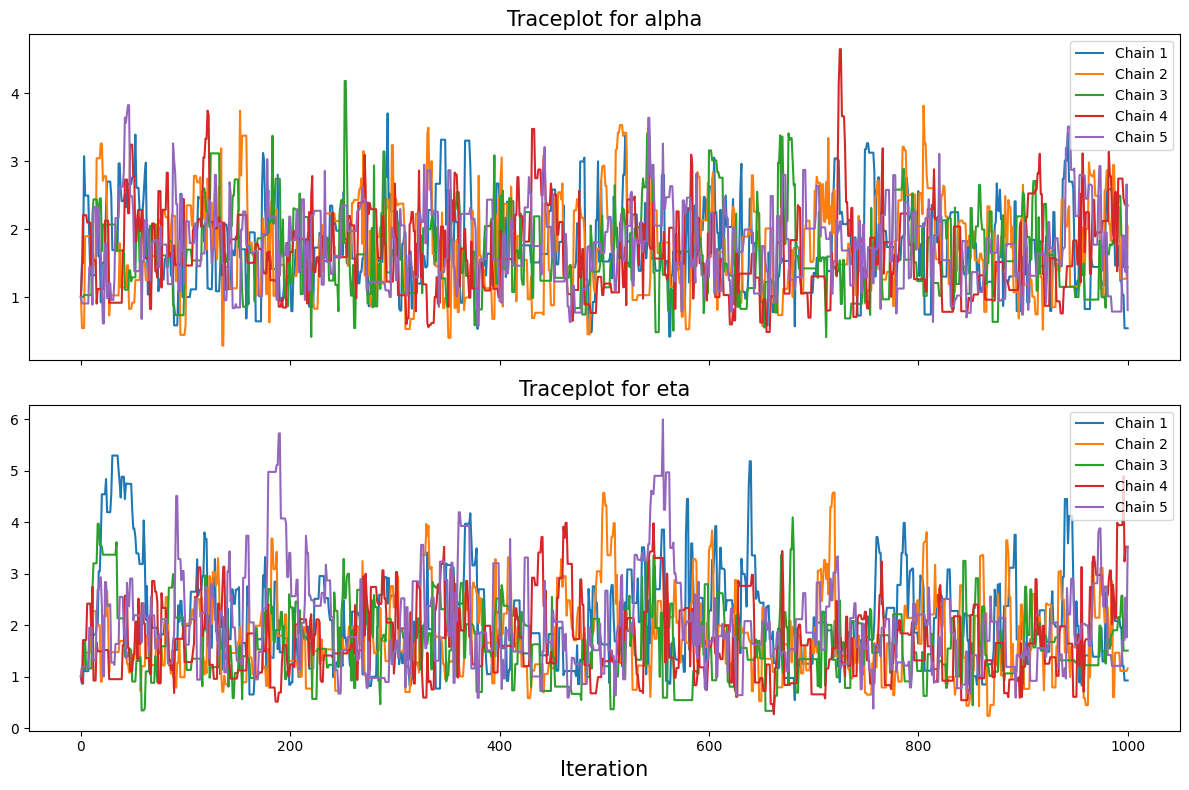

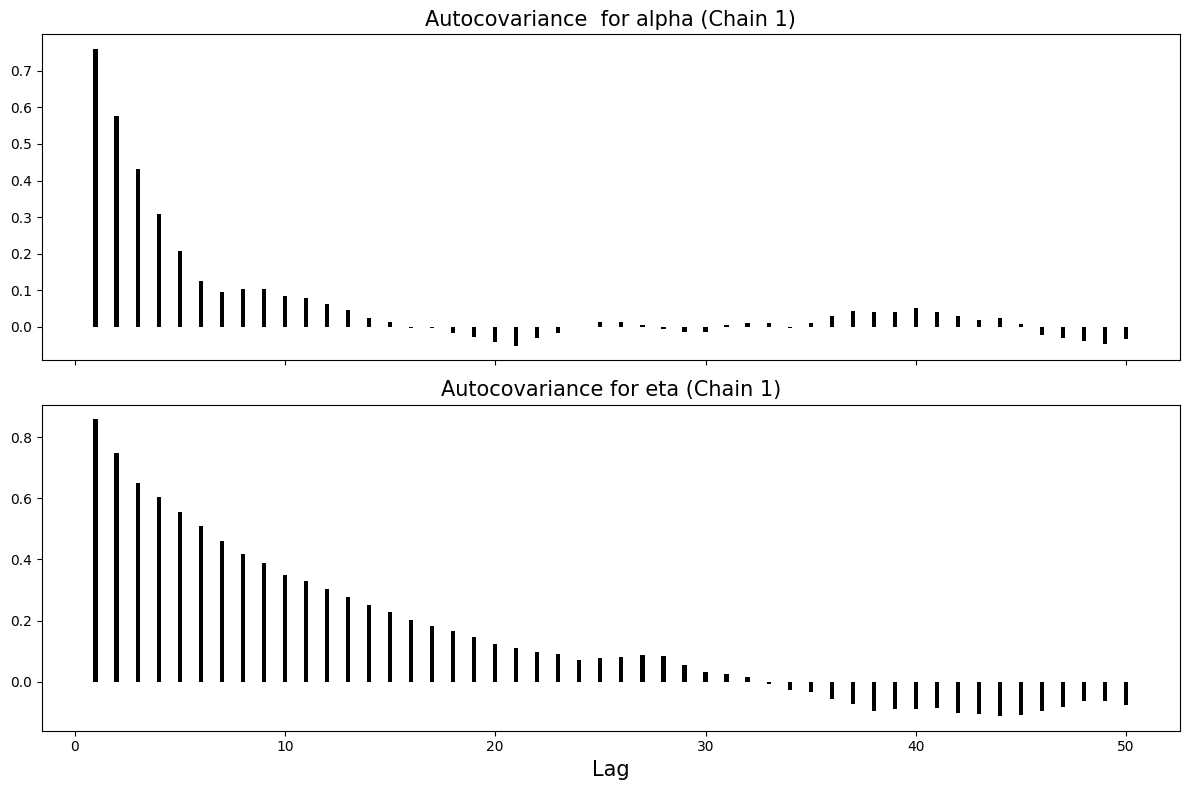

Overall Alpha mean: 1.7010, variance: 0.3869
Overall Eta mean: 1.8327, variance: 0.6918


In [14]:
np.random.seed(42)

num_chains = 5
num_samples = 1000
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
initial_state = [1, 1]

all_samples = []

for i in range(num_chains):
    samples, _ = metropolis_hastings_normal(initial_state, cov, num_samples)
    all_samples.append(np.array(samples))

all_samples = np.array(all_samples)  

# Plot traceplots for alpha and eta across all chains
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i in range(num_chains):
    axs[0].plot(all_samples[i, :, 0], label=f'Chain {i+1}')
    axs[1].plot(all_samples[i, :, 1], label=f'Chain {i+1}')

axs[0].set_title('Traceplot for alpha', fontsize = 15)
axs[1].set_title('Traceplot for eta', fontsize = 15)
axs[1].set_xlabel('Iteration', fontsize = 15)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.savefig("report/figures/mvn_trace.png")
plt.show()

max_lag = 50
lags = np.arange(1, max_lag + 1)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Use only the first chain 
alpha_acorr = [autocorr(all_samples[0, :, 0], lag) for lag in lags]
eta_acorr = [autocorr(all_samples[0, :, 1], lag) for lag in lags]

axs[0].bar(lags, alpha_acorr, color='black', width = 0.2)
axs[1].bar(lags, eta_acorr, color='black', width = 0.2)

axs[0].set_title('Autocovariance  for alpha (Chain 1)', fontsize = 15)
axs[1].set_title('Autocovariance for eta (Chain 1)', fontsize = 15)
axs[1].set_xlabel('Lag', fontsize = 15)

plt.tight_layout()
plt.savefig("report/figures/mvn_cov.png")
plt.show()

all_alpha = all_samples[:, :, 0].flatten()
all_eta = all_samples[:, :, 1].flatten()

print(f"Overall Alpha mean: {np.mean(all_alpha):.4f}, variance: {np.var(all_alpha, ddof=1):.4f}")
print(f"Overall Eta mean: {np.mean(all_eta):.4f}, variance: {np.var(all_eta, ddof=1):.4f}")


In [15]:
# Estimate probability that alpha >= 1.3 and eta >= 1.3
mask = (all_alpha>= 1.3) & (all_eta >= 1.3)
prob_estimate = np.mean(mask)

print(f"Estimated P = {prob_estimate:.4f}")

Estimated P = 0.5562


## 3.2 The exponential proposal

In [16]:
def metropolis_hastings_exp(initial_state, N = 1000, posterior = posterior):
    samples = [np.array(initial_state)]

    accept_count = 0

    for _ in range(N):
        current = samples[-1]
        alpha, eta = current[0], current[1]

        # Sample from Exp(1/alpha), Exp(1/eta)
        alpha_prime = -alpha * np.log(np.random.rand())
        eta_prime = -eta * np.log(np.random.rand())
        proposal = np.array([alpha_prime, eta_prime])

        p_current = posterior(alpha, eta)
        p_proposal = posterior(alpha_prime, eta_prime)

        q_forward = (1/alpha) * np.exp(-alpha_prime/alpha) * (1/eta) * np.exp(-eta_prime/eta)
        q_backward = (1/alpha_prime) * np.exp(-alpha/alpha_prime) * (1/eta_prime) * np.exp(-eta/eta_prime)

        if p_current == 0:
            accept_ratio = 1
        else:
            accept_ratio = min((p_proposal * q_backward) / (p_current * q_forward), 1) *1.5

        if accept_ratio >= np.random.rand():
            samples.append(proposal)
            accept_count += 1

        else:
            samples.append(current)

    accept_rate = accept_count / N

    return np.array(samples), accept_rate


### Diagnostics

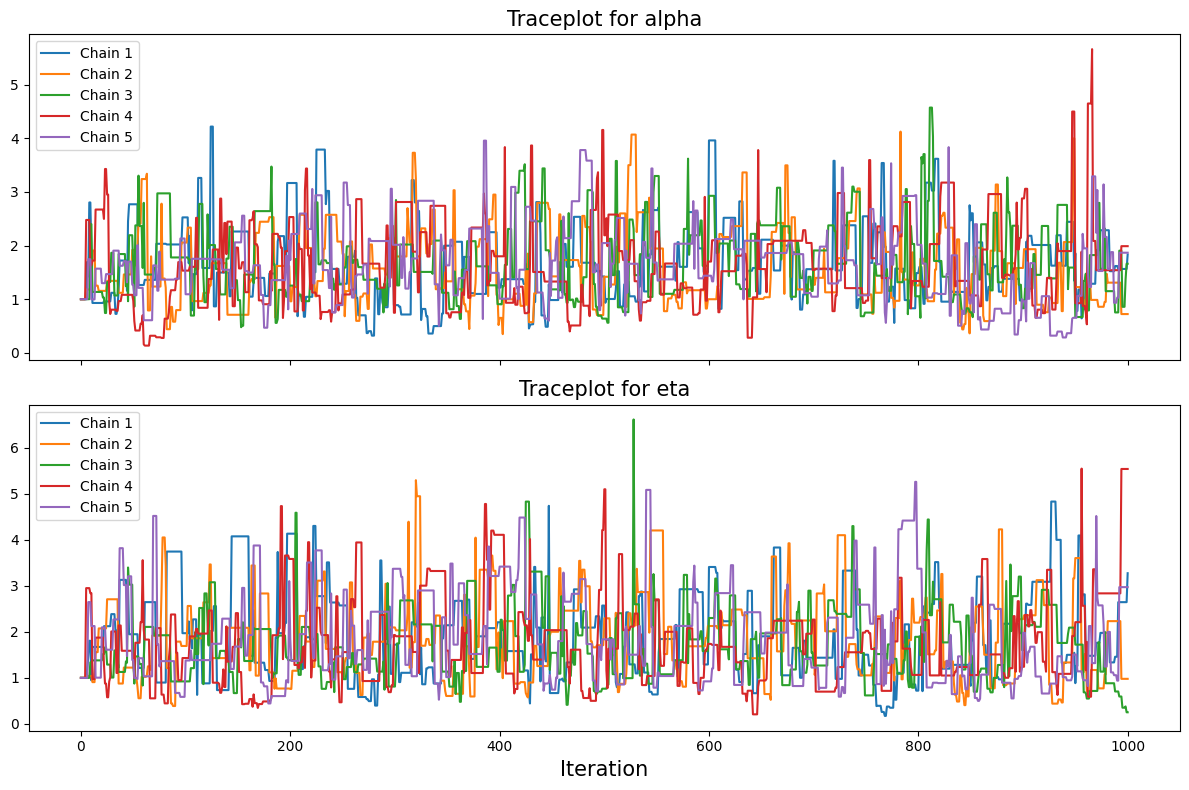

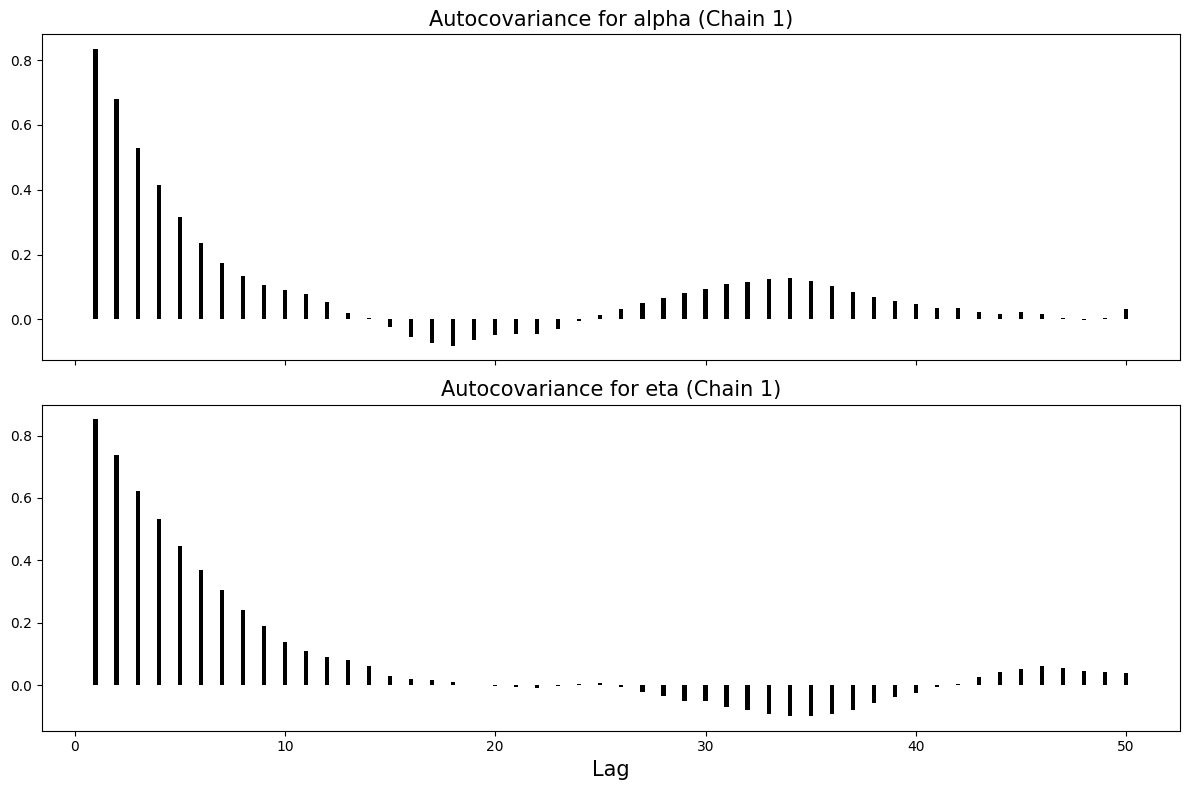

Total ESS for alpha across all chains: 486.41
Total ESS for eta across all chains: 484.12
Overall Alpha mean: 1.6501, variance: 0.5179
Overall Eta mean: 1.8212, variance: 0.8255


In [17]:
np.random.seed(42)

num_chains = 5
num_samples = 1000
initial_state = [1, 1]

all_samples = []

for i in range(num_chains):
    samples, _ = metropolis_hastings_exp(initial_state, N=num_samples)
    all_samples.append(np.array(samples))  

all_samples = np.array(all_samples)  

# Plot traceplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for i in range(num_chains):
    axs[0].plot(all_samples[i, :, 0], label=f'Chain {i+1}')
    axs[1].plot(all_samples[i, :, 1], label=f'Chain {i+1}')

axs[0].set_title('Traceplot for alpha', fontsize=15)
axs[1].set_title('Traceplot for eta', fontsize=15)
axs[1].set_xlabel('Iteration', fontsize=15)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.savefig("report/figures/exp_trace.png")
plt.show()

# Autocorrelation plots + ESS
max_lag = 50
lags = np.arange(1, max_lag + 1)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

alpha_chain1 = all_samples[0, :, 0]
eta_chain1 = all_samples[0, :, 1]

alpha_acorr = [autocorr(alpha_chain1, lag) for lag in lags]
eta_acorr = [autocorr(eta_chain1, lag) for lag in lags]

axs[0].bar(lags, alpha_acorr, color='black', width=0.2)
axs[1].bar(lags, eta_acorr, color='black', width=0.2)


axs[0].set_title(f'Autocovariance for alpha (Chain 1)', fontsize=15)
axs[1].set_title(f'Autocovariance for eta (Chain 1)', fontsize=15)
axs[1].set_xlabel('Lag', fontsize=15)

plt.tight_layout()
plt.savefig("report/figures/exp_cov.png")
plt.show()
ess_alpha_total = 0
ess_eta_total = 0

for i in range(num_chains):
    ess_alpha_total += compute_ess(all_samples[i, :, 0])
    ess_eta_total += compute_ess(all_samples[i, :, 1])

print(f"Total ESS for alpha across all chains: {ess_alpha_total:.2f}")
print(f"Total ESS for eta across all chains: {ess_eta_total:.2f}")


# Calculate overall mean and variance across all chains and samples
all_alpha_samples = all_samples[:, :, 0].flatten()
all_eta_samples = all_samples[:, :, 1].flatten()

alpha_mean = np.mean(all_alpha_samples)
alpha_var = np.var(all_alpha_samples, ddof=1)

eta_mean = np.mean(all_eta_samples)
eta_var = np.var(all_eta_samples, ddof=1)

print(f"Overall Alpha mean: {alpha_mean:.4f}, variance: {alpha_var:.4f}")
print(f"Overall Eta mean: {eta_mean:.4f}, variance: {eta_var:.4f}")


### Esimating the probability 

In [18]:
# Estimate probability that alpha >= 1.3 and eta >= 1.3
mask = (all_alpha_samples >= 1.3) & (all_eta_samples >= 1.3)
prob_estimate = np.mean(mask)

print(f"Estimated P = {prob_estimate:.4f}")


Estimated P = 0.4635
